# 4. Training Models

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Linear Regression

A linear regression model is one of the form

\begin{equation}
    \hat{y} 
        = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
        = h_{\mathbf{\theta}}(\mathbf{x})
        = \mathbf{\theta}^T \mathbf{x}
\end{equation}

**Terminology**
   - $\theta_0$ is the *bias* or the *intercept*
   - $\theta_j$ $(j>0)$ are the *feature weights*
   - $\mathbf{\theta}$ is the *parameter* vector
   - $\mathbf{x}$ is the *feature* vector
   - $h_{\mathbf{\theta}}$ is the hypothesis function
   
The MSE for a Linear Regression hypothesis function $h_{\mathbf{\theta}}$ on a training set $\mathbf{X}$ is

\begin{equation}
    \text{MSE}\left( \mathbf{X}, h_{\mathbf{\theta}}\right)
        = \frac{1}{m} \sum_{i=1}^m\left( h_{\mathbf{\theta}}(\mathbf{x}^{(i)}) - y^{(i)}\right)^2
        = \frac{1}{m} \sum_{i=1}^m\left( \mathbf{\theta}^T \mathbf{x}^{(i)} - y^{(i)}\right)^2
\end{equation}

Intercept: 4.65
Coefficient: 2.87


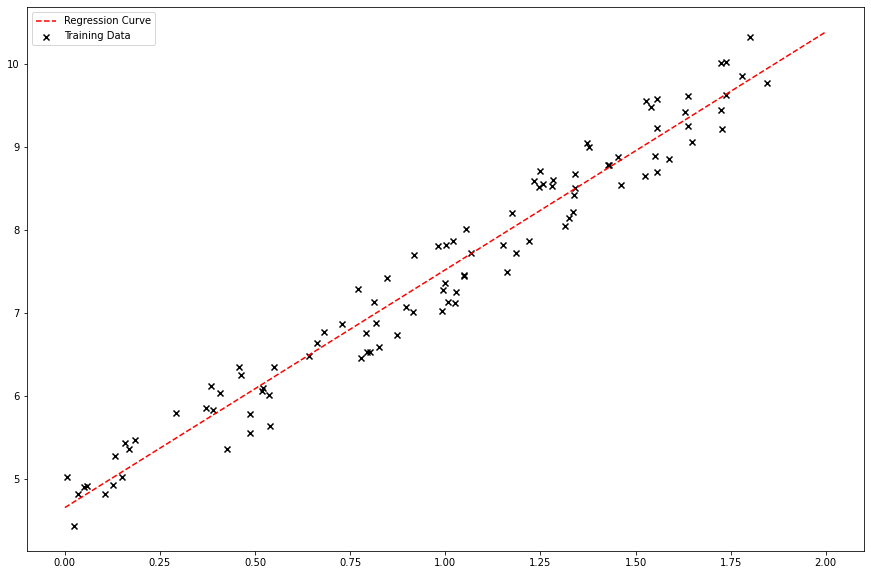

In [33]:
# simple example of training Linear Regression model on sample data.
from sklearn.linear_model import LinearRegression

# generate some sample data
X = 2 * np.random.rand(100, 1) # sampled from [0,1) with shape (100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

# fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("Intercept: {:.2f}".format(lin_reg.intercept_[0]))
print("Coefficient: {:.2f}".format(lin_reg.coef_[0][0]))

# generate data to plot regression curve
X_new = np.linspace(0, 2, 101)
X_new = np.c_[X_new] # predict expects shape (m, 1), not (m)
y_pred = lin_reg.predict(X_new)

# plot curve against training data
fig, ax = plt.subplots(figsize = (15, 10))

ax.scatter(X, y, color="k", marker="x", label="Training Data")
ax.plot(X_new, y_pred, ls="--", color="red", label="Regression Curve")

ax.legend();

**The Normal Equation:** The *Normal Equation* is

\begin{equation}
    \hat{\mathbf{\theta}} = \left(\mathbf{X}^T\mathbf{X}\right)^{-1} \mathbf{X}^T\mathbf{y}.
\end{equation}

- This minimises the Cost Function $\text{MSE}(\mathbf{\theta})$.
- This equation doesn't work if $\mathbf{X}^T\mathbf{X}$ is *singular*, e.g. if $m < n$
- Instead we use the *pseudo-inverse* $\mathbf{X}^+$ of $\mathbf{X}$: $\hat{\mathbf{\theta}} = \mathbf{X}^+\mathbf{y}$
- The pseudo-inverse is calculated using the *Singular Value Decomposition* (SVD): if $\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$ then $\mathbf{X}^+=\mathbf{V}\mathbf{\Sigma}^+\mathbf{U}^T$

In [48]:
# you can manually calculate theta_hat using np.linalg.lstsq ('least squares')

# add bias (columns of 1s) to X
bias = np.ones(len(y))
X_bias = np.c_[bias, X]

theta, residuals, rank, s = np.linalg.lstsq(X_bias, y, rcond=None)

print("Intercept: {:.2f}".format(theta[0][0]))
print("Coefficient: {:.2f}".format(theta[1][0]))

Intercept: 4.65
Coefficient: 2.87
[[4.64893558]
 [2.87146421]]


In [49]:
# ...or by calculating the pseudo-inverse
X_inv = np.linalg.pinv(X_bias)
theta = X_inv.dot(y)
print("Intercept: {:.2f}".format(theta[0][0]))
print("Coefficient: {:.2f}".format(theta[1][0]))

Intercept: 4.65
Coefficient: 2.87


**Computation Complexity**
- Linear regression using SVD has computation complexity of roughly $O(n^2)$ and $O(m)$
- So, doubling the number of features increases training time by 4 and doubling the number of samples doubles the training time
- Training linear regression models can get slow if there are a lot of features (say 100k), but it can handle large training sets
- But once trained, making predictions is linear in both instances and features

## Gradient Descent

**Gradient Descent:** A generic optimisation algorithm which starts with a *random initialisation* of $\mathbf{\theta}$ and takes small steps in the direction of greatest descent until converges to a minimum
- The size of the steps is the *learning rate*
- If the learning rate is too low it will take a long time to converge, if it is too high then it may fail to converge
- Gradient descent can fail if it approaches a local minimum or a plateau, but will always converge (with a suitable learning rate) for convex problems
- Minimising the cost function for linear regression is a convex problem
- Gradient descent can also be slow if the parameters are on very different scales - so you should always use feature scaling

**Batch Gradient Descent:** The gradient of the cost function is

\begin{equation}
    \nabla \text{MSE}(\mathbf{\theta})
        =\left( \frac{\partial}{\partial \theta_j}\text{MSE}(\mathbf{\theta})\right)_j
        = \left( \frac{2}{m} \sum_{i=1}^m \left(\mathbf{\theta}^T\mathbf{x}^{(i)} - y^{(i)}\right)x_j^{(i)}\right)_j
        = \frac{2}{m}\mathbf{X}^T\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)
\end{equation}

and a gradient descent step looks like

\begin{equation}
    \theta^{(\text{next})} = \theta - \eta \nabla \text{MSE}(\mathbf{\theta})
\end{equation}

where $\eta$ is the learning rate.

- Note that calculation of the gradient uses the whole training set $\mathbf{X}$ so is slow on large training sets, though is scales much better than SVD decomposition with the number of features
- You can use grid search to find a good learning rate (so learning rate is a *hyperparameter*)
- Generally we set a *tolerance* $\epsilon$ and run gradient descent for either a certain number of interations, or until the norm of the gradient vector is less than the $\epsilon$
- For a convex cost function whose slope doesn't channge abruptly, gradient descent will always converge, but can take $O(1/\epsilon)$ iterations to get within tolerance $\epsilon$
- Two hyperparameters: $\eta$ and $\epsilon$

**Stochastic Gradient Descent:** This is just gradient descent, but at each step you calculate the gradient using a single (randomly selected) sample from the training set.
- Each step is much faster to compute, but the algorithm takes more steps to converge as it generally doesn't take steps of greatest descent
- Because of the stochasticity, the algorithm can jump of out local minima, but will also continue to 'bounce around' when it approaches the global minimum
- To resolve this we set a *learning schedule*: we set a large initial learning rate and gradually decrease it. This increases the number of hyperparameters (e.g. $\eta$ might be replaced by initial learning rate $\eta_0$ and final learning rate $\eta_1$ with a linear slop betweenn them)
- By convention, we interate by *epochs* of $m$ (=`n_samples`) iterations
- Note that because we pick training instances randomly, some will be selected multiple times per epoch, some not at all
- The training instances *must* be randomised, if e.g. they are ordered by class, then we will go in one direction for a period, then switch direction, rather than really moving randomly
- Since only one instance is used at time, SGD is amenable to *Out-of-Core Learning*

In [44]:
# stochastic gradient descent for linear regression is implemented in SGDRegressor
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-3,
    penalty=None, # regularisation
    eta0=0.1 # initial linear rate
)
sgd_reg.fit(X, y.ravel()) # ravel changes y from (m,1) to (m,)

print("Intercept: {:.2f}".format(sgd_reg.intercept_[0]))
print("Coefficient: {:.2f}".format(sgd_reg.coef_[0]))

Intercept: 4.62
Coefficient: 2.90


**Mini-Batch Gradient Descent:** This is similar to SGD except that we use a mini-batch of instances to calculate the gradient for each steps, instead of a single instance.
- Essentially the reason to use this is that it improves performancne because of optimisationn of matrix operations
- Now mini-batch size is an additional hyper-parameter

**Summary**

| Algorithm | Large $m$ | Out-of-core support | Large $n$ | Hyperparams | Scaling required | Scikit-Learn | 
|---|----|---|---|---|---|---|
| Normal Equation | Fast | No | Slow | 0 | No | N/A |
| SVD | Fast | No | Slow | 0 | No | `LinearRegression` |
| Batch GD | Slow | No | Fast | 2 | Yes | `SGDRegressor` |
| Stochastic GD | Fast | Yes | Fast | ≥2 | Yes | `SGDRegressor` |
| Mini-Batch GD | Fast | Yes | Fast | ≥2 | Yes | `SGDRegressor` |

## Polynomial Regression

**Polynomial Regression:** Adding powers of each feature as a new feature and applying linear regression.
- Note that including all polynomial features of degree 3 would include not only $a^3$ and $b^3$, but also $a^2b$ and $ab^2$
- In general $n$ features with polynomial features up to degree $d$ means $(n+d)!/d!n!$ total features

Intercept: 2.49
Coefficient of x: 0.95
Coefficient of x^2: 0.52


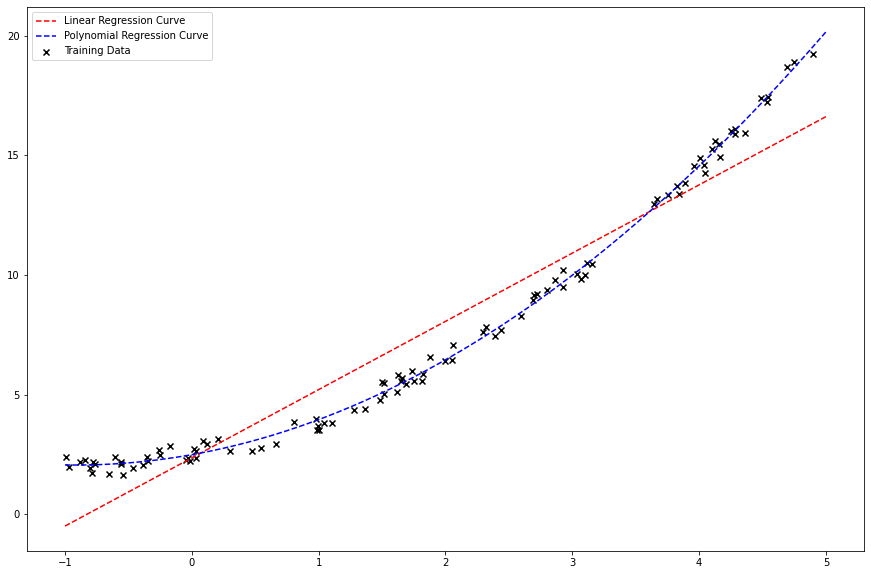

In [56]:
# simple example of polynomial regression on sample data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# generate some sample data
m = 100
X = 6 * np.random.rand(m, 1) - 1 # sampled from [0,1) with shape (m, 1)
y = 0.5 * X**2 + X + 2 + np.random.rand(m, 1)

# fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# generate polynomial features
poly_feat = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_feat.fit_transform(X)

# fit polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
print("Intercept: {:.2f}".format(poly_reg.intercept_[0]))
print("Coefficient of x: {:.2f}".format(poly_reg.coef_[0][0]))
print("Coefficient of x^2: {:.2f}".format(poly_reg.coef_[0][1]))

def plot_regression_curves():
    # generate data
    X_new = np.linspace(-1, 5, 601)
    X_new = np.c_[X_new] # predict expects shape (m, 1), not (m)
    y_lin_pred = lin_reg.predict(X_new)
    
    X_new_poly = poly_feat.transform(X_new)
    y_poly_pred = poly_reg.predict(X_new_poly)

    # plot curves against training data
    fig, ax = plt.subplots(figsize = (15, 10))

    ax.scatter(X, y, color="k", marker="x", label="Training Data")
    ax.plot(X_new, y_lin_pred, ls="--", color="red", label="Linear Regression Curve")
    ax.plot(X_new, y_poly_pred, ls="--", color="blue", label="Polynomial Regression Curve")

    ax.legend();


plot_regression_curves()

## Code Samples

### Computation Time Decorator

Decorators are functions that add additional functionality to other functions

In [38]:
import time

def computation_time(func):
    
    def inner(*args, **kwargs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))
    
    
    return inner


def sleep_copy(seconds):
    return time.sleep(seconds)


sleep_decorated = computation_time(sleep_copy)
sleep_decorated(1)

Computation time: 1.0 seconds


Decorator syntax makes this simpler:

In [39]:
@computation_time
def sleep_decorated(seconds):
    return time.sleep(seconds)


sleep_decorated(1)

Computation time: 1.0 seconds


You can manually calculate $\hat{\mathbf{\theta}}$ using `np.linalg.lstsq()` ('Least Squares'):